# Training NMNIST for deployment on Speck using EXODUS

In [1]:
import sinabs
import sinabs.layers as sl
import torch
import torch.nn as nn
import numpy as np

Let's visualize the neuron model that's supported on chip

In [2]:
iaf = sl.IAF(record_states=True, spike_threshold=5.)

n_steps = 400
input_ = (torch.rand((1, n_steps, 1)) < 0.05).float()
output = iaf(input_)

Text(0.5, 0, 'Time')

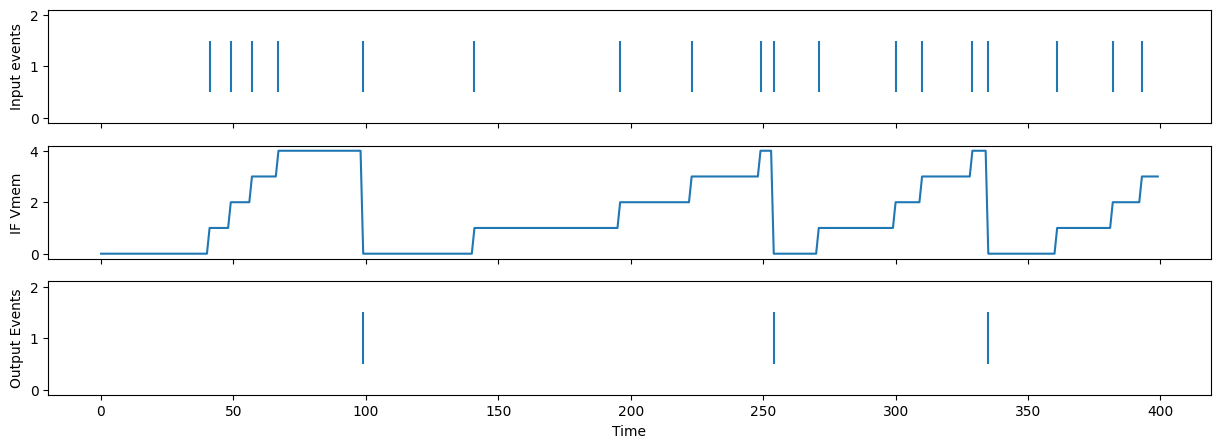

In [3]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(15,5))

ax1.eventplot(torch.where(input_)[1])
ax1.set_ylabel("Input events")
ax2.plot(iaf.recordings['v_mem'].squeeze().numpy())
ax2.set_ylabel("IF Vmem")
ax3.eventplot(torch.where(output)[1])
ax3.set_ylabel("Output Events")
ax3.set_xlabel("Time")

In [4]:
from tonic import datasets, transforms

trainset = datasets.NMNIST('data', train=True)
testset = datasets.NMNIST('data', train=False)

In [5]:
transform = transforms.Compose([
    transforms.ToFrame(sensor_size=trainset.sensor_size, n_time_bins=30, include_incomplete=True),
    lambda x: x.astype(np.float32),
])

events, label = trainset[0]

In [6]:
frames = transform(events)
frames.shape

(30, 2, 34, 34)

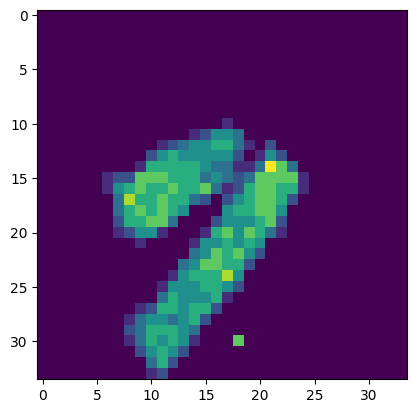

In [7]:
plt.imshow(frames[:10, 0].sum(0))

In [8]:
trainset = datasets.NMNIST('data', train=True, transform=transform)
testset = datasets.NMNIST('data', train=False, transform=transform)

In [9]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, num_workers=4, drop_last=True)

In [10]:
frames = next(iter(trainloader))[0]
frames.shape

torch.Size([16, 30, 2, 34, 34])

In [11]:
import sinabs.exodus.layers as sel

backend = sl # Sinabs
backend = sel # Sinabs EXODUS

model = nn.Sequential(
    sl.FlattenTime(),
    nn.Conv2d(2, 8, kernel_size=3, padding=1, bias=False),
    backend.IAFSqueeze(batch_size=batch_size, min_v_mem=-1),
    sl.SumPool2d(2),
    nn.Conv2d(8, 16, kernel_size=3, padding=1, bias=False),
    backend.IAFSqueeze(batch_size=batch_size, min_v_mem=-1),
    sl.SumPool2d(2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
    backend.IAFSqueeze(batch_size=batch_size, min_v_mem=-1),
    sl.SumPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),
    backend.IAFSqueeze(batch_size=batch_size, min_v_mem=-1),
    sl.SumPool2d(2),
    nn.Conv2d(64, 10, kernel_size=2, padding=0, bias=False),
    backend.IAFSqueeze(batch_size=batch_size, min_v_mem=-1),
    nn.Flatten(),
    sl.UnflattenTime(batch_size=batch_size),
).cuda()

In [12]:
model(frames.cuda()).shape

torch.Size([16, 30, 10])

In [13]:
from tqdm.notebook import tqdm


n_epochs = 1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.functional.cross_entropy

for epoch in range(n_epochs):
    losses = []
    for data, targets in tqdm(trainloader):
        data, targets = data.cuda(), targets.cuda()
        sinabs.reset_states(model)
        optimizer.zero_grad()
        y_hat = model(data)
        pred = y_hat.sum(1)
        loss = crit(pred, targets,)
        loss.backward()
        losses.append(loss)
        optimizer.step()
    print(f"Loss: {torch.stack(losses).mean()}")



  0%|          | 0/3750 [00:00<?, ?it/s]

Loss: 0.27892711758613586


In [14]:
import torchmetrics

acc = torchmetrics.Accuracy('multiclass', num_classes=10).cuda()
model.eval()

for data, targets in tqdm(testloader):
    data, targets = data.cuda(), targets.cuda()
    sinabs.reset_states(model)
    with torch.no_grad():
        y_hat = model(data)
    pred = y_hat.sum(1)
    acc(pred, targets)


  0%|          | 0/625 [00:00<?, ?it/s]

Test accuracy: 0.9707000255584717


In [29]:
print(f"Test accuracy: {100*acc.compute():.2f}%")

Test accuracy: 97.07%


In [15]:
from sinabs.exodus.conversion import exodus_to_sinabs

sinabs_model = exodus_to_sinabs(model)

In [16]:
torch.save(sinabs_model, "nmnist_model.pth")